In [73]:
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  GridSearchCV
from sklearn.metrics import mean_squared_error as MSE
from pyGRNN import GRNN
import pandas as pd
from numpy import newaxis, ravel, mean, var
from scipy.interpolate import CubicSpline


# GRNN

## Data path 1

In [74]:
DATA_PATH_TRUE = 'DS-5-1-GAP-0-1-N-0_v2.csv'
DATA_PATH_NOISE1 = 'DS-5-1-GAP-1-1-N-1_v2.csv'
DATA_PATH_NOISE2 = 'DS-5-1-GAP-5-1-N-3_v2.csv'

d_true = pd.read_csv(DATA_PATH_TRUE, header=None)
d_noise1 = pd.read_csv(DATA_PATH_NOISE1, header=None)
d_noise2 = pd.read_csv(DATA_PATH_NOISE2, header=None)

AGRNN = GRNN(calibration="gradient_search")

X = d_noise1[0]  # time
x = np.array(X)[:, np.newaxis]
Y = d_noise1[1]  # mag_A
y = np.array(Y)[:, np.newaxis]

X_test = d_true[0]
Y_test = d_true[1]

# Training
AGRNN.fit(x, y.ravel())

x_test = np.array(X_test)[:, np.newaxis]
y_test = np.array(Y_test)[:, np.newaxis]

sigma=AGRNN.sigma 
y_pred = AGRNN.predict(x_test)
mse_AGRNN = MSE(y_test, y_pred)


print("MSE from RGNN: ",mse_AGRNN)

MSE from RGNN:  6.920582184023526e-05


## Data path 2

In [75]:

AGRNN = GRNN(calibration="gradient_search")

X = d_noise2[0]  # time
x = np.array(X)[:, np.newaxis]
Y = d_noise2[1]  # mag_A
y = np.array(Y)[:, np.newaxis]

X_test = d_true[0]
Y_test = d_true[1]

# Training
AGRNN.fit(x, y.ravel())

x_test = np.array(X_test)[:, np.newaxis]
y_test = np.array(Y_test)[:, np.newaxis]

sigma=AGRNN.sigma 
y_pred = AGRNN.predict(x_test)
mse_AGRNN = MSE(y_test, y_pred)

print("MSE from RGNN: ",mse_AGRNN)

MSE from RGNN:  0.0019035860131693119


# Others regression Models

## Polynomial Regression

In [76]:

import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

In [77]:
# GT: Artificial data with 50 samples, 0 gaps and noise level 0, 1 realization per sample
df_GAP0_N0 = pd.read_csv("DS-5-1-GAP-0-1-N-0_v2.csv", header=None)
df_GAP0_N0.name = 'DS-5-1-GAP-0-1-N-0_v2'
# print(df_GAP0_N0)

# DS1: Artificial data with 45 samples, 1 gap and noise level 1, 100 realizations per sample
df_GAP1_N1 = pd.read_csv("DS-5-1-GAP-1-1-N-1_v2.csv", header=None)
df_GAP1_N1.name = 'DS-5-1-GAP-1-1-N-1_v2'
# print(df_GAP1_N1)

# DS2: Artificial data with 25 samples, 5 gaps and noise level 3, 100 realizations per sample
df_GAP5_N3 = pd.read_csv("DS-5-1-GAP-5-1-N-3_v2.csv", header=None)
df_GAP5_N3.name = 'DS-5-1-GAP-5-1-N-3_v2'
# print(df_GAP5_N3)

In [78]:
def to_column(series):
    return series.values.reshape(-1, 1)

### Data set 1

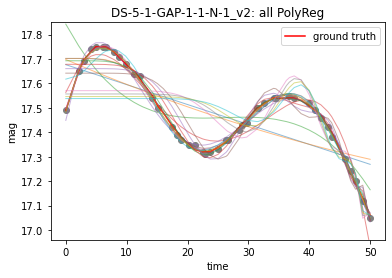

In [79]:
x_test = to_column(df_GAP0_N0[0])
y_test = to_column(df_GAP0_N0[1])

x_train = to_column(df_GAP1_N1[0])
y_train = to_column(df_GAP1_N1[1])

plt.title(f'{df_GAP1_N1.name}: all PolyReg')
plt.xlabel('time')
plt.ylabel('mag')
plt.scatter(x_train, y_train, color = 'grey')
plt.plot(x_test, y_test, 'r', label = 'ground truth')
plt.ylim(y_test.min() - 0.1, y_test.max() + 0.1)

n0 = 1
nf = 20

MSE_template = {'n':[], 'MSE':[]}

MSE_train = pd.DataFrame(MSE_template)
MSE_test = pd.DataFrame(MSE_template)

model = {}

for n in range(n0, nf + 1):

    # training
    model[n] = Pipeline([('poly', PolynomialFeatures(degree = n, include_bias = False)), ('linear', LinearRegression())])
    model[n].fit(x_train, y_train)

    # testing
    y_pred_train = model[n].predict(x_train)
    y_pred_test = model[n].predict(x_test)

    # evaluation
    MSE_train.loc[n-1] = [n, mean_squared_error(y_train, y_pred_train)]
    MSE_test.loc[n-1] = [n, mean_squared_error(y_test, y_pred_test)]

    plt.plot(x_test, y_pred_test, linewidth = 1, alpha = 0.5)

plt.legend(loc="best")
plt.show()

In [80]:


best = MSE_test['n'][MSE_test['MSE'].idxmin()]
y_pred_test = model[best].predict(x_test)

best_MSE_test = MSE_test.loc[MSE_test['n'] == best, 'MSE'].values[0]
best_MSE_train = MSE_train.loc[MSE_train['n'] == best, 'MSE'].values[0]


print(f'training MSE: {best_MSE_train}')
print(f'testing MSE: {best_MSE_test}')

training MSE: 5.734428944041208e-05
testing MSE: 6.33023120956079e-05


### Data set 2

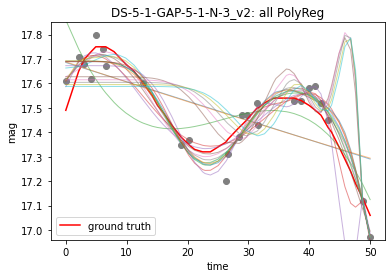

In [81]:
x_test = to_column(df_GAP0_N0[0])
y_test = to_column(df_GAP0_N0[1])

x_train = to_column(df_GAP5_N3[0])
y_train = to_column(df_GAP5_N3[1])

plt.title(f'{df_GAP5_N3.name}: all PolyReg')
plt.xlabel('time')
plt.ylabel('mag')
plt.scatter(x_train, y_train, color = 'grey')
plt.plot(x_test, y_test, 'r', label = 'ground truth')
plt.ylim(y_test.min() - 0.1, y_test.max() + 0.1)

n0 = 1
nf = 20

MSE_template = {'n':[], 'MSE':[]}

MSE_train = pd.DataFrame(MSE_template)
MSE_test = pd.DataFrame(MSE_template)

model = {}

for n in range(n0, nf + 1):

    # training
    model[n] = Pipeline([('poly', PolynomialFeatures(degree = n, include_bias = False)), ('linear', LinearRegression())])
    model[n].fit(x_train, y_train)

    # testing
    y_pred_train = model[n].predict(x_train)
    y_pred_test = model[n].predict(x_test)

    # evaluation
    MSE_train.loc[n-1] = [n, mean_squared_error(y_train, y_pred_train)]
    MSE_test.loc[n-1] = [n, mean_squared_error(y_test, y_pred_test)]

    plt.plot(x_test, y_pred_test, linewidth = 1, alpha = 0.5)

plt.legend(loc="best")
plt.show()

In [82]:
best = MSE_test['n'][MSE_test['MSE'].idxmin()]
y_pred_test = model[best].predict(x_test)

best_MSE_test = MSE_test.loc[MSE_test['n'] == best, 'MSE'].values[0]
best_MSE_train = MSE_train.loc[MSE_train['n'] == best, 'MSE'].values[0]

print(f'training MSE: {best_MSE_train}')
print(f'testing MSE: {best_MSE_test}')

training MSE: 0.002609884681315314
testing MSE: 0.001295502736104876


## Cubic Splines

In [83]:
def plot_cubic_spline(x_train, y_train, x_test, y_test, cs, title):
    plt.title(title)
    plt.scatter(x_train, y_train, color='grey', label='Datos de entrenamiento')
    plt.plot(x_test, y_test, 'r', label='Verdad fundamental')
    plt.plot(x_test, cs(x_test), 'g', label='Spline cúbico')
    plt.xlabel('tiempo')
    plt.ylabel('mag')
    plt.legend(loc='best')
    plt.show()

def evaluate_cubic_spline(x_train, y_train, x_test, y_test):
    cs = CubicSpline(x_train.squeeze(), y_train.squeeze())
    plot_cubic_spline(x_train, y_train, x_test, y_test, cs, 'Interpolación de Spline Cúbico')

    # Evaluate
    y_pred_train = cs(x_train)
    y_pred_test = cs(x_test)

    # Calcule MSE
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)

    # Calcule Bias
    bias_train = np.mean(np.abs(y_pred_train - y_train))
    bias_test = np.mean(np.abs(y_pred_test - y_test))

    # Variance
    variance_train = np.mean(np.square(y_pred_train - np.mean(y_pred_train)))
    variance_test = np.mean(np.square(y_pred_test - np.mean(y_pred_test)))

    return mse_train, mse_test, bias_train, bias_test, variance_train, variance_test

### Data set 1

In [84]:
# Reading data
d_true = pd.read_csv("DS-5-1-GAP-0-1-N-0_v2.csv", header=None)
d_noise1 = pd.read_csv("DS-5-1-GAP-1-1-N-1_v2.csv", header=None)
d_noise1.name = 'DS-5-1-GAP-1-1-N-1_v2.csv'
d_true.name = 'DS-5-1-GAP-0-1-N-0_v2.csv'


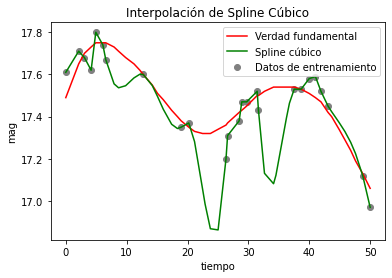

Results for First Dataset:
MSE (Training): 0.0
MSE (Testing): 0.027667228488156424
Bias (Training): 0.0
Bias (Testing): 0.10509971099017726
Variance (Training): 0.03671456000000007
Variance (Testing): 0.04943694364875455


In [85]:
# For First Dataset 'DS-5-1-GAP-1-1-N-1__v2.csv'
mse_train1, mse_test1, bias_train1, bias_test1, variance_train1, variance_test1 = evaluate_cubic_spline(
    x_train, y_train, x_test, y_test
)
# Print results for the first dataset
print("Results for First Dataset:")
print(f"MSE (Training): {mse_train1}")
print(f"MSE (Testing): {mse_test1}")
print(f"Bias (Training): {bias_train1}")
print(f"Bias (Testing): {bias_test1}")
print(f"Variance (Training): {variance_train1}")
print(f"Variance (Testing): {variance_test1}")

### Data set 2

In [86]:
# Reading data
d_true = pd.read_csv("DS-5-1-GAP-0-1-N-0_v2.csv", header=None)
d_noise2 = pd.read_csv("DS-5-1-GAP-5-1-N-3_v2.csv", header=None)
d_noise2.name = 'DS-5-1-GAP-1-1-N-1_v2.csv'
d_true.name = 'DS-5-1-GAP-5-1-N-3_v2.csv'

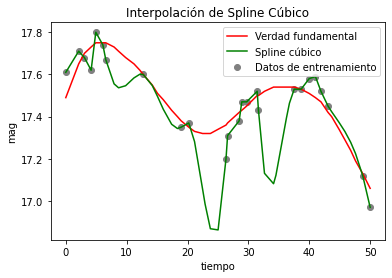


Resultados para el Segundo Conjunto de Datos:
MSE (Entrenamiento): 0.0
MSE (Pruebas): 0.027667228488156424
Bias (Entrenamiento): 0.0
Bias (Pruebas): 0.10509971099017726
Varianza (Entrenamiento): 0.03671456000000007
Varianza (Pruebas): 0.04943694364875455


In [87]:
# Para el segundo conjunto de datos 'DS-5-1-GAP-5-1-N-3__v2.csv'
x_train2 = to_column(d_noise2[0])
y_train2 = to_column(d_noise2[1])

mse_train2, mse_test2, bias_train2, bias_test2, variance_train2, variance_test2 = evaluate_cubic_spline(
    x_train2, y_train2, x_test, y_test
)

# Imprimir resultados para el segundo conjunto de datos
print("\nResultados para el Segundo Conjunto de Datos:")
print(f"MSE (Entrenamiento): {mse_train2}")
print(f"MSE (Pruebas): {mse_test2}")
print(f"Bias (Entrenamiento): {bias_train2}")
print(f"Bias (Pruebas): {bias_test2}")
print(f"Varianza (Entrenamiento): {variance_train2}")
print(f"Varianza (Pruebas): {variance_test2}")

# Conclusion
The differents methods help us to do specific task if it is needed, but in this case the GRNN is the best option for almost every dataset here.

## References
- https://github.com/federhub/pyGRNN
- http://neupy.com/apidocs/neupy.algorithms.rbfn.grnn.html
- Shared homework "Polynomial Regressions" by Mikel Barajas